In [305]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import pandas as pd
import pickle
import itertools
import numpy as np
import torch
from test_functions import problem_setup
import seaborn as sns
import matplotlib as mpl
mpl.rcParams["figure.dpi"]= 120
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False

import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [306]:
kernel = "default"
problem_strs_dict = {
    "vehiclesafety_5d3d_kumaraswamyproduct": "Vehicle safety (d=5, k=3) \n Product of Kumaraswamy CDFs",
    'dtlz2_8d4d_negl1dist': 'DTLZ2 (d=8, k=4) \n L1 distance',
    'osy_6d8d_piecewiselinear': 'OSY (d=6, k=8) \n Piece-wise linear',
    "carcabdesign_7d9d_piecewiselinear": "Car cab design (d=7, k=9) \n Piece-wise linear", 
    
    "vehiclesafety_5d3d_piecewiselinear": "Vehicle safety (d=5, k=3) \n Piece-wise linear",
    "dtlz2_8d4d_piecewiselinear": "DTLZ2 (d=8, k=4) \n Piece-wise linear",
    'osy_6d8d_sigmodconstraints': 'OSY (d=6, k=8) \n Exp. func. sum with sigmoid constraints',
    "carcabdesign_7d9d_linear": "Car cab design (d=7, k=9) \n Linear",
}

mt_problem_strs_dict = {
    "vehiclesafety_5d3d_kumaraswamyproduct": "Vehicle safety (d=5, k=3) \n Product of Kumaraswamy CDFs",
    'dtlz2_8d4d_negl1dist': 'DTLZ2 (d=8, k=4) \n L1 distance',
    'osy_6d8d_piecewiselinear': 'OSY (d=6, k=8) \n Piece-wise linear',
    "carcabdesign_7d9d_piecewiselinear": "Car cab design (d=7, k=9) \n Piece-wise linear", 
}


In [405]:
sns_cp = sns.color_palette()
print(f"total color: {len(sns_cp)}")
# color, line pattern
cl_map = {
#     "EUBO": (sns_cp[6], "-."),
    r"EUBO-$\tilde{f}$": (sns_cp[0], "-", "."),
    r"EUBO-$\mathcal{Y}_0$": (sns_cp[0], "-.", "x"),

#     "EUBO-RW": (sns_cp[5], "-"),
    r"EUBO-$\zeta$": (sns_cp[4], "-", "."),
    
#     "BALD f_mean": (sns_cp[1], "-"),
    r"BALD-$\tilde{f}$": (sns_cp[1], "-", "."),
    r"BALD-$\mathcal{Y}_0$": (sns_cp[1], "-.", "x"),
    
#     "PBO EI": (sns_cp[4], "-"),
    "PBO TS": (sns_cp[5], "-", "."),
    "PBO EUBO": (sns_cp[5], "-.", "x"),

#     "Surrogate Random": (sns_cp[3], "-"),
    r"Random-$\tilde{f}$": (sns_cp[3], "-", "."),
    r"Random-$\mathcal{Y}_0$": (sns_cp[3], "-.", "x"),

    "MOBO (qNParEGO)": (sns_cp[2], "-", "."),

    "Random Experiment": (sns_cp[7], "-.", "x"),
    "True Utility": ("black", "-", ".")
}

# Make sure we don't have duplicate patterns
assert len(set(cl_map.keys())) == len(set(cl_map.values()))

total color: 10


## Within-Session Simulation Result Plots

In [455]:
within_df = pd.read_pickle("../data/processed/within_session.pickle")
for i in within_df['strategy_name'].unique():
    print(f'"{i}",')

within_df['strategy_name'] = within_df['strategy_name'].astype("category").cat.set_categories(cl_map.keys())
within_df = within_df.sort_values(["strategy_name", "sim_idx"])

within_df.head(3)

"BALD-$\mathcal{Y}_0$",
"BALD-$\tilde{f}$",
"EUBO-$\mathcal{Y}_0$",
"EUBO-$\tilde{f}$",
"EUBO-$\zeta$",
"Random-$\mathcal{Y}_0$",
"Random-$\tilde{f}$",


,problem_str,strategy_name,sim_idx,noiseless,keep_winner_prob,util_mean,util_std,count,log_opt_gap_mean,log_opt_gap_std,max_util,util_se,log_opt_gap_se
51,carcabdesign_7d9d_linear,EUBO-$\tilde{f}$,0,True,0,5.064285,0.381106,100,-0.015749,0.364048,6.114008e+00,0.038111,0.036405
170,carcabdesign_7d9d_piecewiselinear,EUBO-$\tilde{f}$,0,True,0,-4.356429,1.635672,100,0.781624,0.528903,-1.810087e+00,0.163567,0.052890
289,dtlz2_8d4d_negl1dist,EUBO-$\tilde{f}$,0,True,0,-1.457866,0.336881,100,0.349415,0.240219,-1.428334e-07,0.033688,0.024022


In [456]:
def plot_within_sim(
    problem_dict,
    data,
    y,
    y_label,
    noiseless,
):
    data = data[data['noiseless'] == noiseless]
    jitter_size = 0.2
    legend_inside = False
    
    n_col = 4
    if len(problem_dict) <= n_col:
        overview_fig, axes = plt.subplots(1, len(problem_dict), figsize=(3.5 * len(problem_dict), 1.75), sharex=True)
    else:
        n_row = len(problem_dict) // n_col + int(len(problem_dict) % n_col != 0)
        overview_fig, axes = plt.subplots(n_row, n_col, figsize=(3.75 * n_col, 2.25 * n_row), sharex=True)
    
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, problem_str in enumerate(problem_dict.keys()):
        fig = overview_fig
        ax = axes[i]

        problem_df = data[data['problem_str'] == problem_str]
        if len(problem_df) == 0:
            print(f"{problem_str} not found in df! Skipping...")
            continue
            
        for j, strategy_name in enumerate(problem_df['strategy_name'].unique()):
            line_df = problem_df[problem_df['strategy_name'] == strategy_name]
            x_idx = line_df['sim_idx']
            x_jittered = x_idx + 1 + i * jitter_size/(j+1) - jitter_size
            
            c, l, m = cl_map[strategy_name]
            ax.errorbar(
                x=x_jittered, 
                y=line_df[f"{y}_mean"],
                yerr=1.96 * line_df[f"{y}_se"], 
                label=strategy_name, 
                linewidth=1.1, 
                color=c, 
                linestyle=l
            )

        ax.set_title(problem_strs_dict[problem_str], fontsize=10)

    for i, ax in enumerate(axes):
        ylim = ax.get_ylim()
        ax.set_xlabel("Number of comparisons")
        if i % n_col == 0:
            ax.set_ylabel(y_label)

        sns.despine(ax=ax)
        
        if i >= len(problem_dict):
            ax.set_axis_off()

    overview_fig.subplots_adjust(hspace=0.5, wspace=0.25)

    if legend_inside:
        axes[0].legend(loc="best", frameon=False, prop={"size": 8})
    else:
        handles, labels = axes[0].get_legend_handles_labels()
        if len(axes) == len(problem_dict):
            legend_y = -0.4 if len(problem_dict) <= 4 else -0.08
            overview_fig.legend(
                handles, 
                labels, 
                loc="lower center",
                ncol=data['strategy_name'].nunique(),
                bbox_to_anchor=(0.5, legend_y),
            )
        else:
            overview_fig.legend(
                handles, 
                labels, 
                bbox_to_anchor=(0.675, 0.075), 
                loc="lower right",
                prop={"size": 12}
            )           

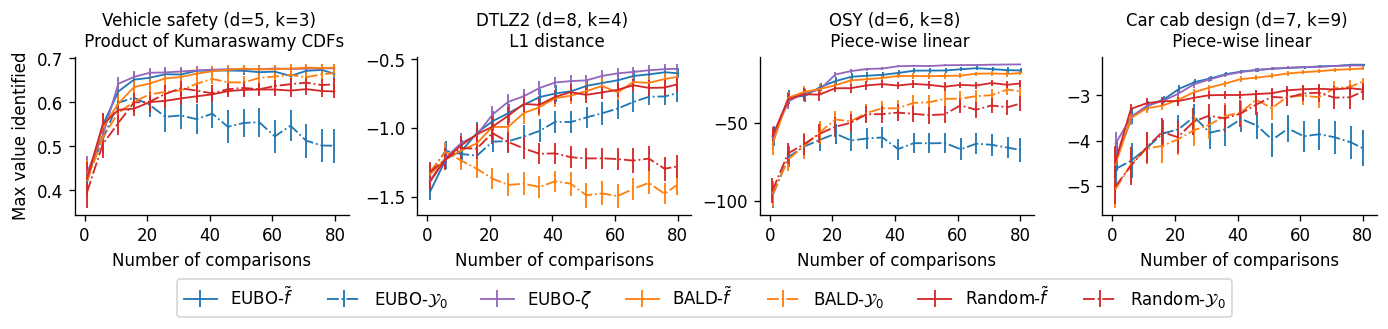

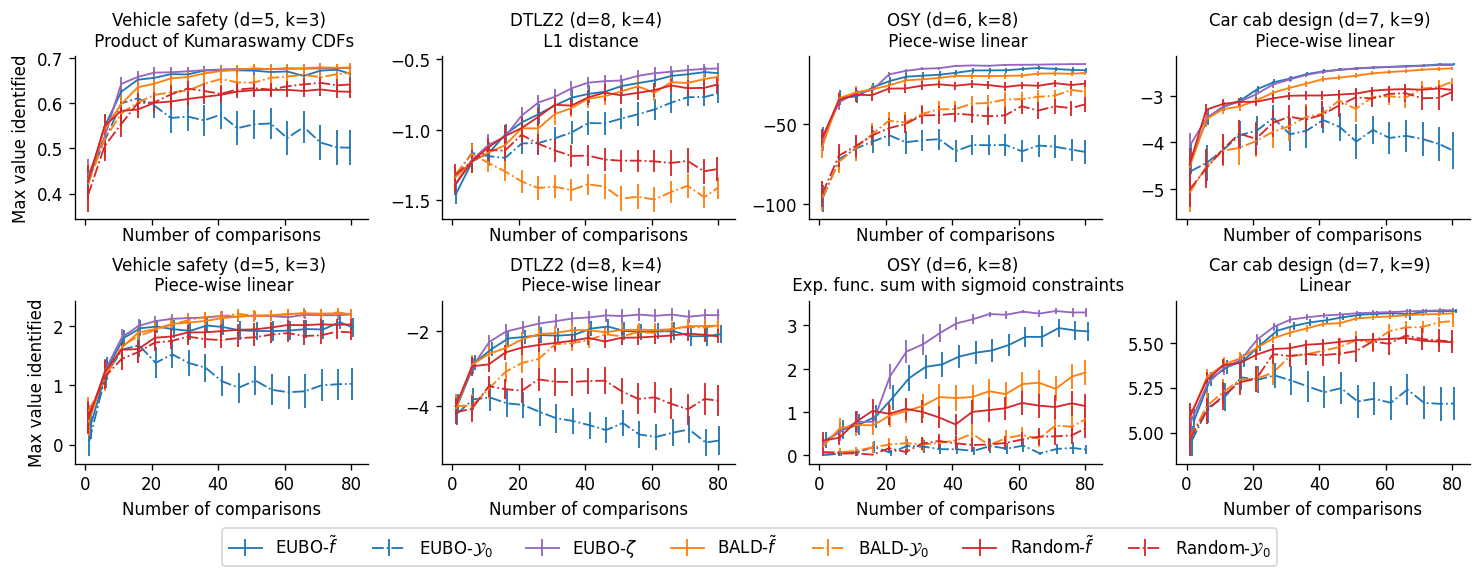

In [457]:
plot_within_sim(
    problem_dict=mt_problem_strs_dict,
    data=within_df,
    noiseless=True,
    y="util",
    y_label="Max value identified",
)
plt.savefig("../plots/mt_within_session.pdf", bbox_inches='tight')

plot_within_sim(
    problem_dict=problem_strs_dict,
    data=within_df,
    noiseless=True,
    y="util",
    y_label="Max value identified",
)

plt.savefig("../plots/all_within_session.pdf", bbox_inches='tight')


## Multi-Batch Simulation Result Plots

In [447]:
def plot_multi_batch_sim(
    problem_dict,
    data,
    y,
    y_label,
    title=None,
    use_marker=False,
    bottom_legend=True,
    bbox_to_anchor=None
):
    jitter_size = 0.05
    legend_inside = False

    if len(problem_dict) <= 4:
#         overview_fig, axes = plt.subplots(1, len(problem_dict), figsize=(3.25 * len(problem_dict), 2.25), sharex=True)
        overview_fig, axes = plt.subplots(1, len(problem_dict), figsize=(3.5 * len(problem_dict), 2), sharex=True)
    else:
        n_row = len(problem_dict) // 4 + int(len(problem_dict) % 4 != 0)
        overview_fig, axes = plt.subplots(n_row, 4, figsize=(15, 2.25 * n_row), sharex=True)

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, problem_str in enumerate(problem_dict.keys()):
        fig = overview_fig
        ax = axes[i]
        try:
            problem_df = data[data['problem_str'] == problem_str]
        except:
            print(f"{problem_str} not found in df! Skipping...")
            continue
        
        policy_names = problem_df['policy'].unique()
        for j, policy_name in enumerate(policy_names):
            line_df = problem_df[problem_df['policy'] == policy_name]
            x_idx = line_df['batch']
            x_jittered = x_idx + 1 + 2 * (j+1) * jitter_size/len(policy_names) - jitter_size
                
            c, l, m = cl_map[policy_name]
            
            ax.errorbar(
                x=x_jittered, 
                y=line_df[f"{y}_mean"], 
                yerr=1.96 * line_df[f"{y}_se"], 
                label=policy_name, 
                linewidth=1.1,
                linestyle=l,
                color=c,
                marker=m if use_marker else '',
            )

        ax.set_title(problem_strs_dict[problem_str], fontsize=10)

    for i, ax in enumerate(axes):
        ylim = ax.get_ylim()
        ax.set_xlabel("Batch", fontsize=10)
        if i % 4 == 0:
            ax.set_ylabel(y_label, fontsize=10)

        sns.despine(ax=ax)
        
        if i >= len(problem_dict):
            ax.set_axis_off()
            
    overview_fig.subplots_adjust(hspace=0.4, wspace=0.2)
    if title is not None:
        overview_fig.suptitle(title, y=-0.1, fontsize=16)
    
    if legend_inside:
        axes[-1].legend(loc="best", frameon=False, prop={"size": 8})
    else:
        handles, labels = axes[1].get_legend_handles_labels()
        if len(axes) == len(problem_dict):
            if bottom_legend:
                if bbox_to_anchor is None:
                    if len(problem_dict) <= 4:
                        bbox_to_anchor = (0.5, -0.35)
                    else:
                        bbox_to_anchor = (0.5, -0.15)

                
                if data['policy'].nunique() > 9:
                    ncol = 6
                else:
                    ncol = data['policy'].nunique()
                overview_fig.legend(
                    handles, 
                    labels, 
                    bbox_to_anchor=bbox_to_anchor, 
                    loc="lower center",
                    ncol=ncol,
                #                 prop={"size": 9.5}
                )
            else:
                if bbox_to_anchor is None:
                    bbox_to_anchor = (0.9, 1.05)
                overview_fig.legend(
                    handles, 
                    labels, 
                    bbox_to_anchor=bbox_to_anchor, 
                    loc="upper left",
                )
        else:
            if bbox_to_anchor is None:
                bbox_to_anchor = (0.79, 0.12)
            overview_fig.legend(
                handles, 
                labels, 
                ncol=2,
                bbox_to_anchor=bbox_to_anchor, 
                loc="lower right",
                prop={"size": 12}
            )
            
    return overview_fig, axes

# read data
multi_df = pd.read_pickle("../data/processed/multi_batch.pickle")
multi_df['policy'] = multi_df['policy'].astype("category").cat.set_categories(cl_map.keys())
multi_df = multi_df.sort_values(["policy", "batch"])

# Camera ready
## Interactive

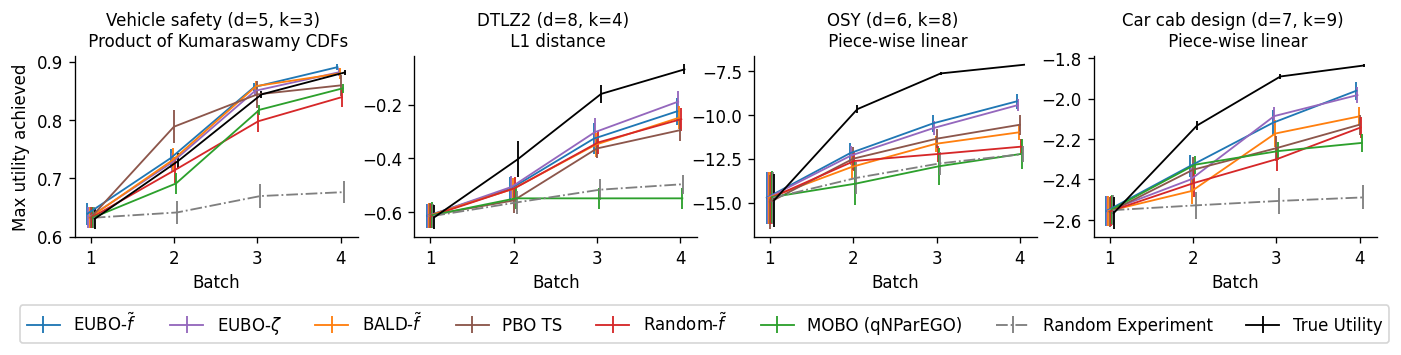

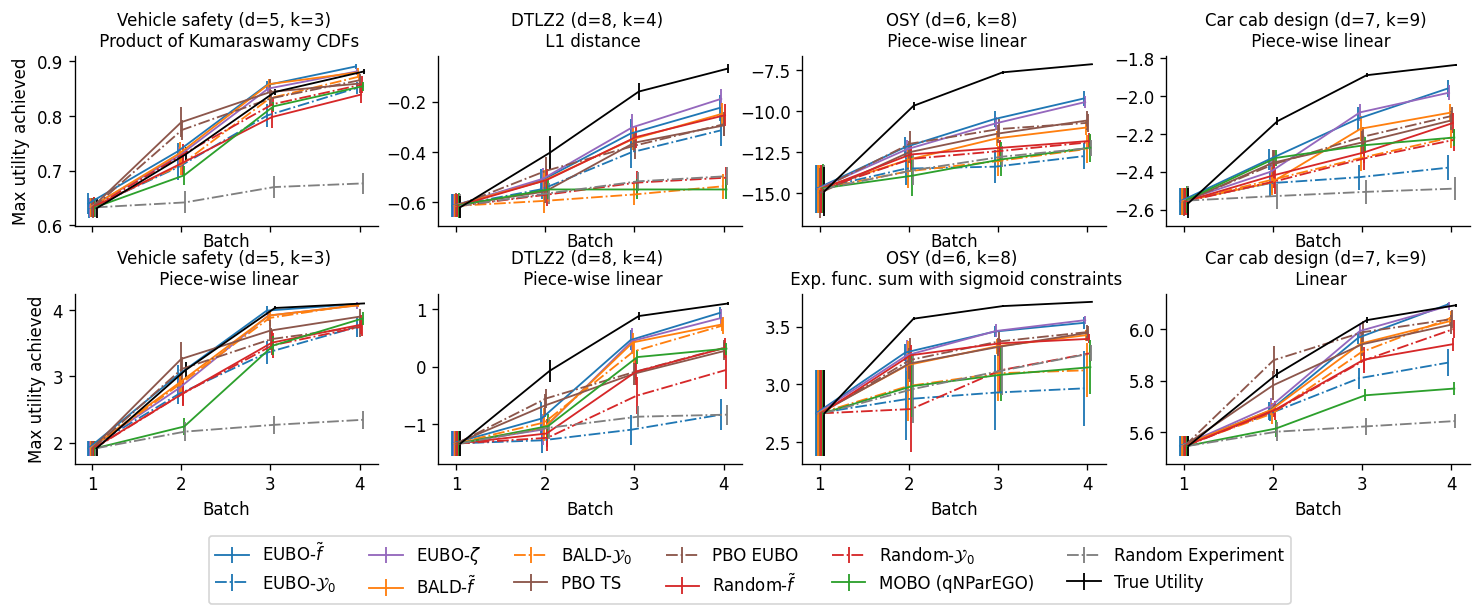

In [448]:
plot_df = multi_df[multi_df['exp_type_str'] == 'noiseless_f const_comp_noise normal_batch interactive']
mt_plot_df = plot_df[~(plot_df['policy'].str.contains('{Y}_0') | plot_df['policy'].isin(["PBO EUBO"]))]
# mt_plot_df = plot_df[~(plot_df['policy'].str.contains('{Y}_0'))]

plot_multi_batch_sim(
    problem_dict=mt_problem_strs_dict,
    data=mt_plot_df,
    y="max_util",
    y_label="Max utility achieved",
#     title="interactive"
)

plt.savefig("../plots/mt_multi_batch_interactive.pdf", bbox_inches='tight')

plot_multi_batch_sim(
    problem_dict=problem_strs_dict,
    data=plot_df,
    y="max_util",
    y_label="Max utility achieved",
#     title="interactive"
)

plt.savefig("../plots/all_multi_batch_interactive.pdf", bbox_inches='tight')

## One-shot experiment

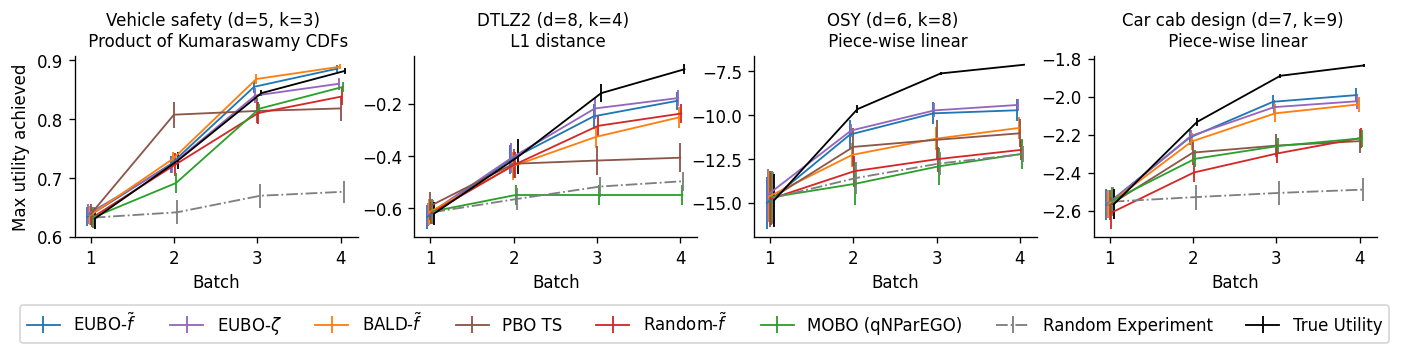

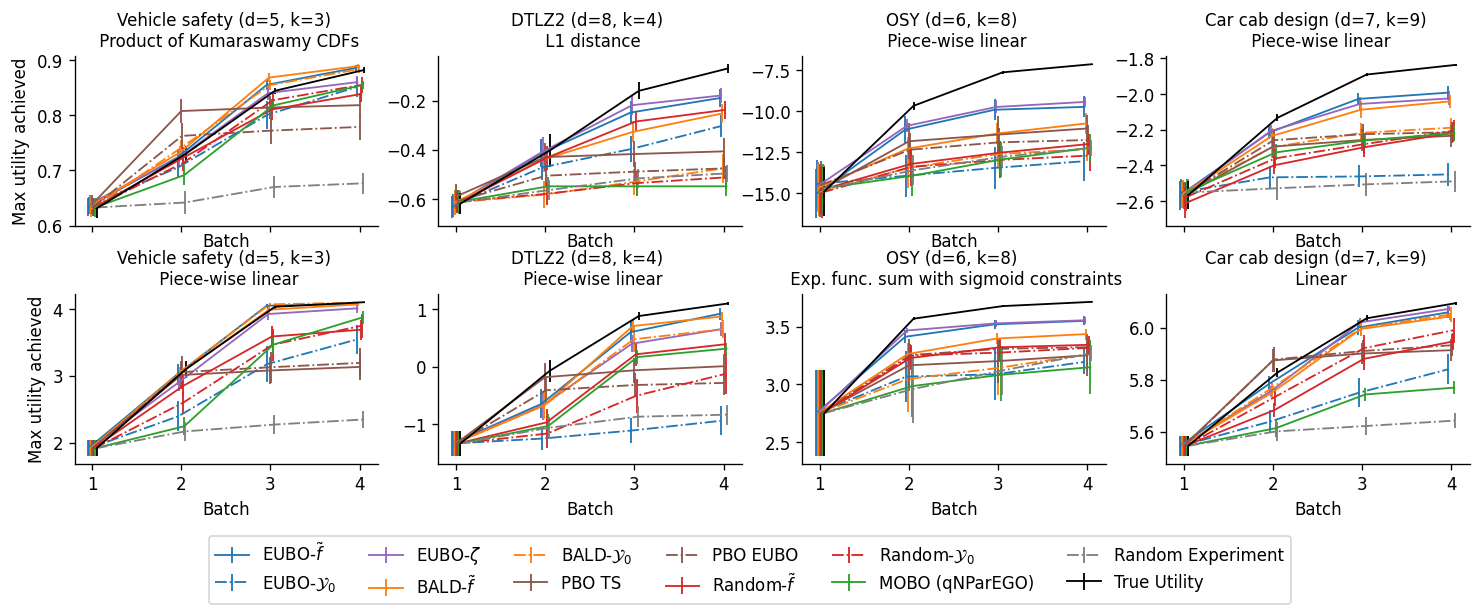

In [449]:
non_pl_baselines_df = multi_df[multi_df['exp_type_str'] == 'noiseless_f const_comp_noise normal_batch interactive']
non_pl_baselines_df = non_pl_baselines_df[non_pl_baselines_df['policy'].isin([ 'MOBO (qNParEGO)', 'Random Experiment', 'True Utility'])]

plot_df = multi_df[multi_df['exp_type_str'] == 'noiseless_f const_comp_noise normal_batch one_shot']
plot_df = pd.concat([plot_df, non_pl_baselines_df])

mt_plot_df = plot_df[~(plot_df['policy'].str.contains('{Y}_0') | plot_df['policy'].isin(["PBO EUBO"]))]

plot_multi_batch_sim(
    problem_dict=mt_problem_strs_dict,
    data=mt_plot_df,
    y="max_util",
    y_label="Max utility achieved",
#     title="One-shot"
)

plt.savefig("../plots/mt_multi_batch_oneshot.pdf", bbox_inches='tight')

plot_multi_batch_sim(
    problem_dict=problem_strs_dict,
    data=plot_df,
    y="max_util",
    y_label="Max utility achieved",
#     title="One-shot"
)

plt.savefig("../plots/all_multi_batch_oneshot.pdf", bbox_inches='tight')

## Interactive vs. one-shot last batch

In [450]:
def plot_interactive_vs_oneshot(
    problem_dict,
    data,
    y,
    y_label,
    title=None,
    plot_diff=True,
    processed=False,
    bottom_legend=True,
    bbox_to_anchor=None,
):
    if not processed:
        interactive_last_batch = data.query("batch == 3 and exp_type_str == 'noiseless_f const_comp_noise normal_batch interactive'")[['problem_str', 'policy', f'{y}_mean', f'{y}_se']]
        oneshot_last_batch = data.query("batch == 3 and exp_type_str == 'noiseless_f const_comp_noise normal_batch one_shot'")[['problem_str', 'policy', f'{y}_mean', f'{y}_se']]
    if plot_diff:
        if not processed:
            merged_last_batch = interactive_last_batch.merge(oneshot_last_batch, on=['problem_str', 'policy'], suffixes=["_interactive", "_oneshot"])
            merged_last_batch['diff_mean'] = merged_last_batch[f'{y}_mean_interactive'] - merged_last_batch[f'{y}_mean_oneshot']
            merged_last_batch['diff_se'] = np.sqrt(merged_last_batch[f'{y}_se_interactive']**2 + merged_last_batch[f'{y}_se_oneshot']**2)
            y = "diff"
        else:
            merged_last_batch = data
        merged_last_batch['batch'] = 3
        overview_fig, axes = plot_multi_batch_sim(
            problem_dict=problem_dict,
            data=merged_last_batch,
            y=y,
            y_label=y_label,
            use_marker=True,
            bottom_legend=bottom_legend,
            bbox_to_anchor=bbox_to_anchor,
        )
        for ax in axes:
            ax.axhline(y=0, color="gray", linestyle="--")
            ax.set_xticks([])
            ax.set_xlabel("")
    else:
        if processed:
            raise RuntimeError("Not supported plotting raw values for processed df!")
        oneshot_last_batch['batch'] = 0
        interactive_last_batch['batch'] = 1
        merged_last_batch = pd.concat([interactive_last_batch, oneshot_last_batch])
            
        merged_last_batch = merged_last_batch[~merged_last_batch['policy'].isin([ 'MOBO (qNParEGO)', 'Random Experiment', 'True Utility'])]
        
        overview_fig, axes = plot_multi_batch_sim(
            problem_dict=problem_dict,
            data=merged_last_batch,
            y=y,
            y_label=y_label,
            use_marker=True,
            bottom_legend=bottom_legend,
            bbox_to_anchor=bbox_to_anchor
        )
        
        for ax in axes:
            ax.set_xticks(ticks=[1, 2], labels=["Single", "Multiple"])
            ax.set_xlim(0, 3)
            ax.set_xlabel("")
            
     
    if title is not None:
        plt.suptitle(title)

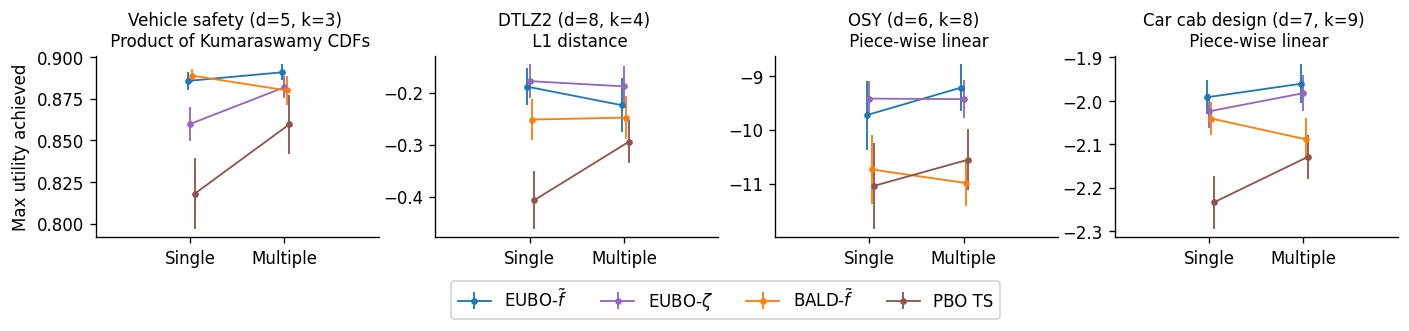

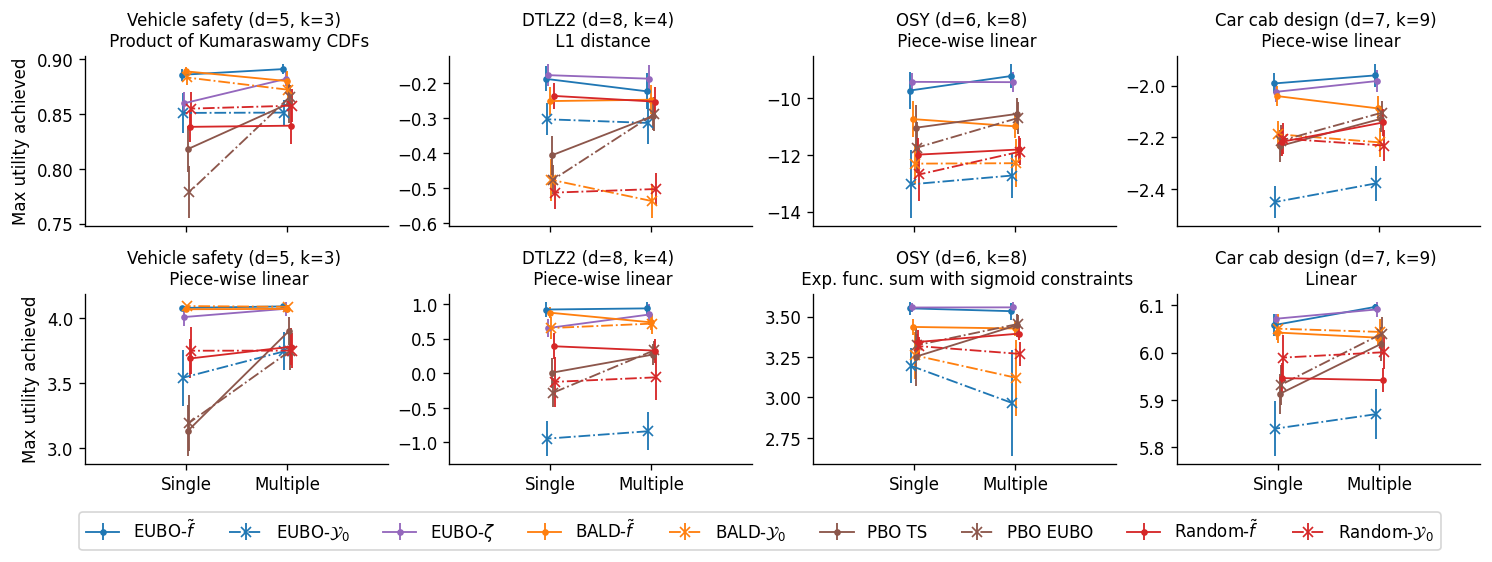

In [451]:
plot_interactive_vs_oneshot(
    problem_dict=mt_problem_strs_dict,
    data=multi_df[(multi_df['policy'].isin([r'EUBO-$\tilde{f}$', r'EUBO-$\zeta$', r'BALD-$\tilde{f}$', 'PBO TS']))],
    y="max_util",
    y_label="Max utility achieved",
    plot_diff=False,
    bottom_legend=True,
    bbox_to_anchor=(0.5, -0.25),
)
plt.savefig("../plots/mt_interactive_oneshot_diff_in_util.pdf", bbox_inches='tight')

plot_interactive_vs_oneshot(
    problem_dict=problem_strs_dict,
    data=multi_df,
    y="max_util",
    y_label="Max utility achieved",
    plot_diff=False,
    bottom_legend=True,
    bbox_to_anchor=(0.5, -0.05)
)
plt.savefig("../plots/interactive_oneshot_diff_in_util.pdf", bbox_inches='tight')

## Probit noise

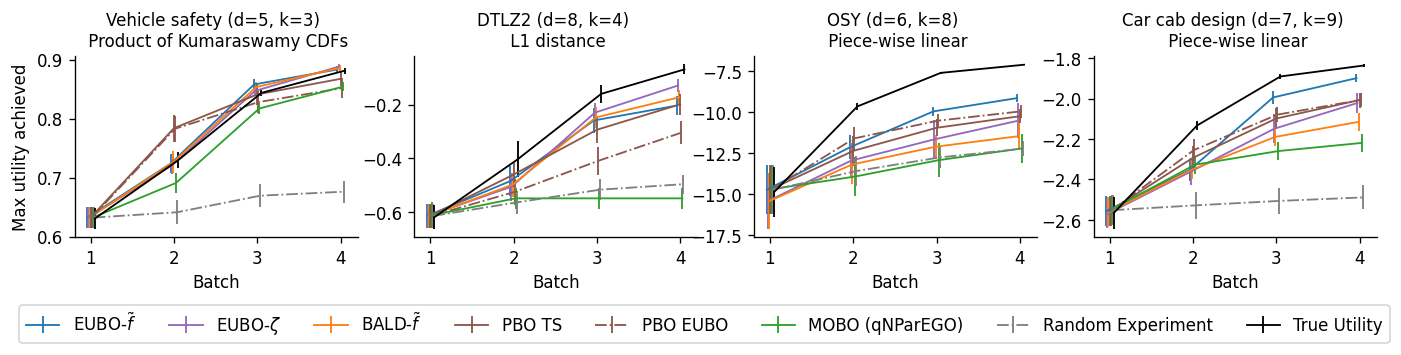

In [454]:
# Probit noise
plot_df = multi_df[(multi_df['exp_type_str'] == 'noiseless_f probit_comp_noise normal_batch interactive') &\
                   (~multi_df['policy'].isin(('MOBO (qNParEGO)', 'Random Experiment', 'True Utility')))]
plot_df = pd.concat([plot_df, non_pl_baselines_df])

plot_multi_batch_sim(
    problem_dict=mt_problem_strs_dict,
    data=plot_df,
    y="max_util",
    y_label="Max utility achieved",
#     title="Probit noise"
)
plt.savefig("../plots/probit_noise.pdf", bbox_inches='tight')